In [10]:
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [11]:
"""yf.Ticker("Turkey")"""

'yf.Ticker("Turkey")'

In [12]:
data = yf.download('AKBNK.IS',interval="1wk")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)

data

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
Date,,,,,,
2000-05-08,6.137479,6.410256,5.864702,6.273867,-128432.023438,4176505
2000-05-15,6.137479,6.273867,5.319148,5.591925,-114472.015625,4232978
2000-05-22,5.346426,5.591925,5.182760,5.455537,-111680.039062,3806653
2000-05-29,5.237315,5.455537,5.182760,5.237315,-107212.820312,5913922
2000-06-05,5.591925,5.728314,0.608362,0.620061,-12693.237305,17222522
...,...,...,...,...,...,...
2023-09-11,32.720001,32.840000,28.160000,28.440001,28.440001,622104948
2023-09-18,28.440001,31.680000,28.020000,30.799999,30.799999,663917323
2023-09-25,30.940001,34.220001,30.840000,33.459999,33.459999,614285132


In [13]:
X_train,X_test,Y_train,Y_test=sk.train_test_split(data.index,data["close"],test_size=0.33, random_state=42)

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [15]:
device= 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [16]:
from copy import deepcopy as dc
def prepareforlstm(df,loookback):
    df=pd.DataFrame(df["close"])
    df=dc(df)
    for i in range(1,loookback+1):
        df[f'close(t-{i})']=df["close"].shift(i)
    df.dropna(inplace=True)
    return df

In [17]:
lookback=7

In [18]:
shifted_df=prepareforlstm(data,lookback)
shifted_df

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,
2000-06-26,0.549865,0.579113,0.549865,0.620061,5.237315,5.455537,5.591925,6.273867
2000-07-03,0.555715,0.549865,0.579113,0.549865,0.620061,5.237315,5.455537,5.591925
2000-07-10,0.526467,0.555715,0.549865,0.579113,0.549865,0.620061,5.237315,5.455537
2000-07-17,0.538166,0.526467,0.555715,0.549865,0.579113,0.549865,0.620061,5.237315
2000-07-24,0.532316,0.538166,0.526467,0.555715,0.549865,0.579113,0.549865,0.620061
...,...,...,...,...,...,...,...,...
2023-09-11,28.440001,32.299999,29.379999,29.940001,28.660000,30.879999,28.299999,28.559999
2023-09-18,30.799999,28.440001,32.299999,29.379999,29.940001,28.660000,30.879999,28.299999
2023-09-25,33.459999,30.799999,28.440001,32.299999,29.379999,29.940001,28.660000,30.879999


In [19]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)
shifted_df_as_np

array([[0.00544698, 0.00632552, 0.0054799 , ..., 0.15931022, 0.17119456,
        0.19354491],
       [0.0056227 , 0.00544698, 0.00636375, ..., 0.15247616, 0.1667245 ,
        0.17119456],
       [0.00474416, 0.0056227 , 0.0054799 , ..., 0.00787731, 0.15957238,
        0.1667245 ],
       ...,
       [0.99399243, 0.9140921 , 0.84829933, ..., 0.92609177, 0.9272405 ,
        1.        ],
       [1.        , 0.99399243, 0.91961676, ..., 0.90855417, 0.96919196,
        0.9272405 ],
       [0.93812231, 1.        , 1.        , ..., 1.        , 0.95083816,
        0.96919196]])

In [20]:
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape

((1212, 7), (1212,))

In [21]:
split_index=int(len(x)*0.90)
split_index2=int(len(x)*0.95)

In [22]:
x_train=torch.tensor(x[:split_index].reshape((-1,lookback,1))).float()
x_val=torch.tensor(x[split_index:split_index2].reshape((-1,lookback,1))).float()
x_test=torch.tensor(x[split_index2:].reshape((-1,lookback,1))).float()
y_train=torch.tensor(y[:split_index].reshape((-1,1))).float()
y_val=torch.tensor(y[split_index:split_index2].reshape((-1,1))).float()
y_test=torch.tensor(y[split_index2:].reshape((-1,1))).float()
x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape

(torch.Size([1090, 7, 1]),
 torch.Size([61, 7, 1]),
 torch.Size([61, 7, 1]),
 torch.Size([1090, 1]),
 torch.Size([61, 1]),
 torch.Size([61, 1]))

In [23]:
from torch.utils.data import Dataset,DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]
    

In [24]:
trainds=TimeSeriesDataset(x_train,y_train)
testds=TimeSeriesDataset(x_test,y_test)
valds=TimeSeriesDataset(x_val,y_val)

In [25]:
batch_size=16
train_loader=DataLoader(trainds,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(testds,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(valds,batch_size=batch_size,shuffle=True)

In [26]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_lay):
        super().__init__()
        self.hidden_size=hidden_size
        self.num_lay=num_lay
        self.lstm=nn.LSTM(input_size,hidden_size,num_lay,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        batch_size=x.size(0)
        h0=torch.zeros(self.num_lay,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_lay,batch_size,self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out

In [27]:
model=LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [28]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch*1}')
    running_loss=0.0
    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)
        output=model(x_batch)
        loss=loss_function(output,y_batch)
        running_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index %100==99:
            avg_loss_across_batches=running_loss/100
            print('Batch {0},loss:{1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss=0.0
    print()

In [29]:
def validate_one_epoch():
    model.train(False)
    running_lose=0.0
    for batch_index,batch in enumerate(val_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)
        with torch.no_grad():
            output=model(x_batch)
            loss=loss_function(output,y_batch)
            running_lose+=loss.item()
    avg_loss_across_batches=running_lose/len(test_loader)
    print('Val loss {0:.3f}'.format(avg_loss_across_batches))
    print('*************************************')
    print()

In [30]:
learning_rate=0.001
num_epochs=30
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 0



Val loss 0.003
*************************************

Epoch: 1

Val loss 0.006
*************************************

Epoch: 2

Val loss 0.007
*************************************

Epoch: 3

Val loss 0.006
*************************************

Epoch: 4

Val loss 0.006
*************************************

Epoch: 5

Val loss 0.006
*************************************

Epoch: 6

Val loss 0.006
*************************************

Epoch: 7

Val loss 0.005
*************************************

Epoch: 8

Val loss 0.005
*************************************

Epoch: 9

Val loss 0.004
*************************************

Epoch: 10

Val loss 0.004
*************************************

Epoch: 11

Val loss 0.002
*************************************

Epoch: 12

Val loss 0.001
*************************************

Epoch: 13

Val loss 0.001
*************************************

Epoch: 14

Val loss 0.001
*************************************

Epoch: 15

Val loss 0.000
******************

In [31]:
with torch.no_grad():
    predicted=model(x_train.to(device)).to('cpu').numpy()
    

In [32]:
torch.cuda.empty_cache()

In [33]:
import matplotlib.pyplot as plt

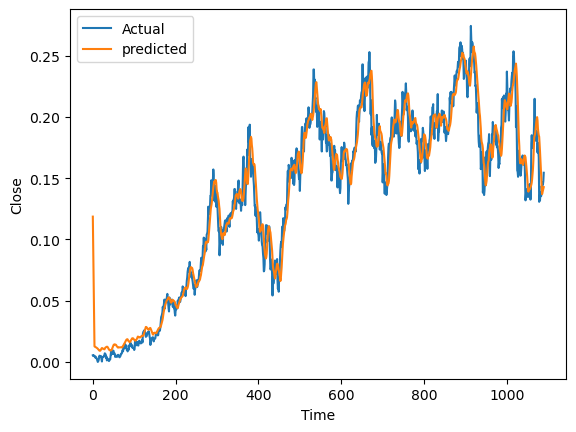

In [34]:
plt.plot(y_train,label="Actual")
plt.plot(predicted,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [35]:
train_prediction=predicted.flatten()
dummies=np.zeros((x_train.shape[0],lookback+1))
dummies[:,0]=train_prediction
dummies=scalar.inverse_transform(dummies)
train_prediction=dc(dummies[:,0])
train_prediction

array([4.31753201, 3.38850437, 2.51047937, ..., 5.01518298, 5.0791919 ,
       5.11958683])

In [36]:
dummies=np.zeros((x_train.shape[0],lookback+1))
dummies[:,0]=y_train.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_train=dc(dummies[:,0])
new_y_train

array([0.54986501, 0.55571502, 0.52646702, ..., 5.19000016, 5.28000027,
       5.51000007])

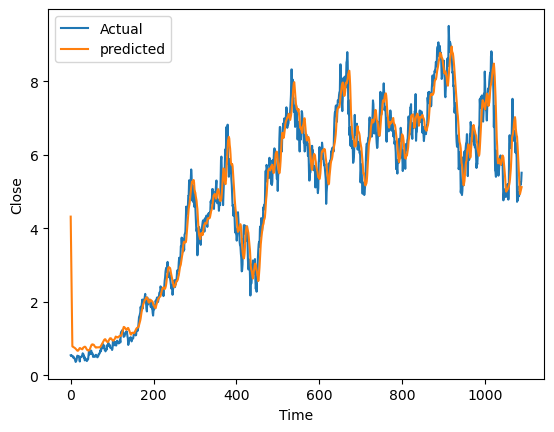

In [37]:
plt.plot(new_y_train,label="Actual")
plt.plot(train_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [38]:
test_prediction=model(x_test.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_test.shape[0],lookback+1))
dummies[:,0]=test_prediction.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction

array([ 8.34787259,  8.52989287,  8.83981489,  9.27845421,  9.7332142 ,
       10.21223159, 10.62483357, 11.0039689 , 11.37567887, 11.5762149 ,
       11.61334363, 11.07144691, 11.16005304, 11.49615824, 11.94907976,
       12.24269855, 12.50670524, 12.46309669, 12.60473593, 12.84509838,
       13.1123425 , 13.25136342, 13.33892579, 13.49262774, 13.76079854,
       13.77849477, 13.6039802 , 13.35526076, 13.12762082, 13.20351337,
       12.90821881, 12.84528788, 12.7899222 , 13.0680821 , 13.23079686,
       13.49717582, 13.62283527, 13.39576583, 13.27444113, 13.16115594,
       13.159375  , 13.17180681, 13.0650054 , 12.88499921, 12.96016351,
       13.22576164, 12.83283425, 13.10880941, 13.64047197, 13.85391802,
       14.03746028, 14.25666683, 14.46340388, 14.7492084 , 15.25522949,
       15.39436848, 15.80442556, 15.85092924, 15.98451112, 15.87562716,
       15.98272919])

In [39]:
dummies=np.zeros((x_test.shape[0],lookback+1))
dummies[:,0]=y_test.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test

array([10.60000072, 11.97999953, 13.0299999 , 15.91999968, 12.1899998 ,
       11.27999961, 11.28999963, 12.85999968, 13.49999952, 15.55000019,
       14.68000005, 14.56999991, 14.97999945, 16.2500001 , 16.81999985,
       16.86000089, 16.66999966, 18.77000138, 19.71999964, 19.54999843,
       18.7000003 , 16.5499995 , 18.70999932, 16.64999963, 16.51000044,
       14.70000008, 15.98999977, 15.95999973, 17.40999962, 19.52000136,
       18.20999867, 17.99999939, 16.940001  , 16.82999986, 17.56999983,
       17.70000099, 16.04999885, 15.23999979, 19.29000007, 14.97999945,
       14.50999983, 17.5499998 , 18.45999999, 18.88999956, 19.79000072,
       20.20000026, 20.26000034, 24.76000022, 23.95999918, 28.55999919,
       28.29999885, 30.87999823, 28.65999932, 29.94000098, 29.37999827,
       32.30000007, 28.44000102, 30.80000011, 33.45999959, 33.65999985,
       31.60000115])

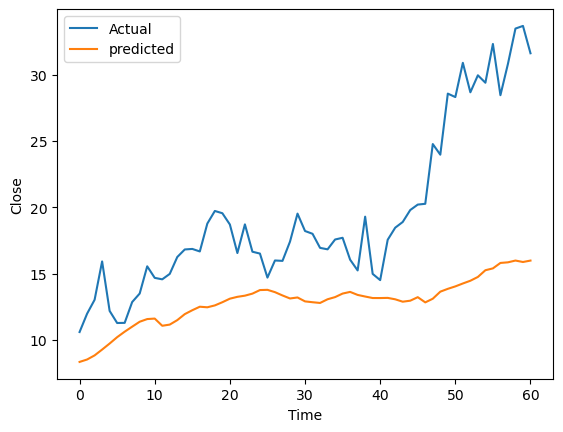

In [40]:
plt.plot(new_y_test,label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [43]:
import yfinance as yf
import pandas as pd 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ta as ta2
import tti
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import random
import numpy as np
import datetime
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [44]:
data = yf.download('GARAN.IS',interval="1wk")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)


data["returns"]=data["close"].pct_change()
from copy import deepcopy as dc
def prepareforlstm(df,lookback):
    df['momentum'] = df['returns'].rolling(5).mean().shift(1)
    df['volatility'] = df['returns'].rolling(20).std().shift(1)
    df['direction'] = np.where(df['returns'] > 0, 1, 0)
    df['distance'] = (df['close'] - df['close'].rolling(50).mean()).shift(1)
    df["mom1"]=ta.MOM(df["close"],1)
    df["mom1"]=df["mom1"].shift(1)
    df["mom2"]=ta.MOM(df["close"],2)
    df["mom2"]=df["mom2"].shift(1)
    df["mom3"]=ta.MOM(df["close"],3)
    df["mom3"]=df["mom3"].shift(1) 
    df["ema_10"]=ta.EMA(df["close"],10)
    df["ema_10"]=df["ema_10"].shift(1)
    df["ema_20"]=ta.EMA(df["close"],20)
    df["ema_20"]=df["ema_20"].shift(1)
    df["ema_50"]=ta.EMA(df["close"],50)
    df["ema_50"]=df["ema_50"].shift(1)
    df["roc5"]=ta.ROC(df["close"],5)
    df["roc5"]=df["roc5"].shift(1)
    df["roc10"]=ta.ROC(df["close"],10)
    df["roc10"]=df["roc10"].shift(1)
    df["roc15"]=ta.ROC(df["close"],15)
    df["roc15"]=df["roc15"].shift(1)
    df["roc20"]=ta.ROC(df["close"],20)
    df["roc20"]=df["roc20"].shift(1)
    df=dc(df)
    for i in range(1,lookback+1):
        df[f'close(t-{i})']=df["close"].shift(i)
    df.dropna(inplace=True)
    df.drop(["low","high","open","adj close","volume","returns"],axis=1,inplace=True)
    
    return df
shifted_df=prepareforlstm(data,7)
shifted_df.info()

[*********************100%%**********************]  1 of 1 completed


NameError: name 'ta' is not defined

In [ ]:
shifted_df

,close,momentum,volatility,direction,distance,mom1,mom2,mom3,ema_10,ema_20,...,roc10,roc15,roc20,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-15,7.730000,0.001109,0.013003,1,-0.201400,-0.040000,0.120000,0.120000,7.511882,7.533589,...,4.252400,1.740296,-0.131409,7.600000,7.640000,7.480000,7.480000,7.510000,7.560000,7.530000
2016-12-16,7.720000,0.005853,0.013535,0,-0.064800,0.130000,0.090000,0.250000,7.551540,7.552295,...,7.361114,5.601091,1.178012,7.730000,7.600000,7.640000,7.480000,7.480000,7.510000,7.560000
2016-12-19,7.630000,0.006393,0.013434,0,-0.068000,-0.010000,0.120000,0.080000,7.582169,7.568266,...,5.177107,5.320599,0.259740,7.720000,7.730000,7.600000,7.640000,7.480000,7.480000,7.510000
2016-12-20,7.720000,0.004062,0.013489,1,-0.149200,-0.090000,-0.100000,0.030000,7.590866,7.574146,...,4.234972,2.830189,0.131237,7.630000,7.720000,7.730000,7.600000,7.640000,7.480000,7.480000
2016-12-21,7.760000,0.002143,0.013738,1,-0.052800,0.090000,0.000000,-0.010000,7.614345,7.588037,...,2.523235,5.177107,1.312335,7.720000,7.630000,7.720000,7.730000,7.600000,7.640000,7.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,54.000000,0.009634,0.019340,1,3.918000,2.150002,2.450001,1.799999,51.423740,51.045911,...,6.500000,1.816445,4.719767,53.250000,51.099998,50.799999,51.450001,51.549999,50.799999,52.000000
2023-10-03,53.299999,0.009498,0.019480,0,4.322800,0.750000,2.900002,3.200001,51.892151,51.327252,...,8.870971,7.462687,5.365854,54.000000,53.250000,51.099998,50.799999,51.450001,51.549999,50.799999
2023-10-04,51.700001,0.007294,0.019639,0,3.282799,-0.700001,0.049999,2.200001,52.148123,51.515133,...,6.493507,7.546404,2.697491,53.299999,54.000000,53.250000,51.099998,50.799999,51.450001,51.549999


In [46]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils import to_categorical
import keras_tuner as kt


Using TensorFlow backend


In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    # gather input and output parts of the pattern
    X, y = sequences.iloc[:, 1:], sequences.iloc[:, 0]
    return np.array(X), np.array(y).reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(shifted_df2, n_steps)


In [ ]:
X.shape

(1735, 21)

In [ ]:
"""from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
n_steps = 5
lookback=X.shape[1]
# convert into input/output
X, Y = split_sequences(shifted_df2, n_steps)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:].reshape((-1,1,lookback))
x_val=X[split_index:split_index2,:].reshape((-1,1,lookback))
x_test=X[split_index2:,:].reshape((-1,1,lookback))
y_train=Y[:split_index,].reshape((-1,1))
y_val=Y[split_index:split_index2,].reshape((-1,1))
y_test=Y[split_index2:,].reshape((-1,1))
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]



with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(units=1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='mean_squared_error')
model.fit(x_train,y_train, verbose=1,shuffle=1,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)"""

"from sklearn.preprocessing import MinMaxScaler,StandardScaler\nscalar=MinMaxScaler(feature_range=(0,1))\nshifted_df_as_np=scalar.fit_transform(shifted_df)\n\nshifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)\nn_steps = 5\nlookback=X.shape[1]\n# convert into input/output\nX, Y = split_sequences(shifted_df2, n_steps)\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=X[:split_index,:].reshape((-1,1,lookback))\nx_val=X[split_index:split_index2,:].reshape((-1,1,lookback))\nx_test=X[split_index2:,:].reshape((-1,1,lookback))\ny_train=Y[:split_index,].reshape((-1,1))\ny_val=Y[split_index:split_index2,].reshape((-1,1))\ny_test=Y[split_index2:,].reshape((-1,1))\nx_train.shape,x_test.shape,y_train.shape,y_test.shape\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\n\nn_features=x_train.shape[2]\n\n\n\nwith tf.device('/GPU:0'):\n    set_seeds()\n    model = Sequential()\n    mod

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
n_steps = 5
lookback=X.shape[1]
# convert into input/output
X, Y = split_sequences(shifted_df2, n_steps)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:].reshape((-1,1,lookback))
x_val=X[split_index:split_index2,:].reshape((-1,1,lookback))
x_test=X[split_index2:,:].reshape((-1,1,lookback))
y_train=Y[:split_index,].reshape((-1,1))
y_val=Y[split_index:split_index2,].reshape((-1,1))
y_test=Y[split_index2:,].reshape((-1,1))
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1.0,0.1,0.01,0.001])
    hp_units=hp.Choice('units', values=[8,16,32,64,128 ])
    with tf.device('/GPU:0'):
        set_seeds()
        model = Sequential()
        model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dense(units=1))
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    return model
tuner=kt.RandomSearch(model_builder,objective="val_loss",overwrite=1,max_trials=5)
tuner.search(x_train,y_train,verbose=1,shuffle=1 ,epochs=100,validation_data=(x_val,y_val),callbacks=[early_stopping])
best_model=tuner.get_best_models()[0]
best_model.evaluate(x_train,y_train)

Trial 5 Complete [00h 00m 06s]
val_loss: 0.00014369374548550695

Best val_loss So Far: 6.045422196621075e-05
Total elapsed time: 00h 00m 50s
30/30 [==============================] - 1s 7ms/step - loss: 1.5860e-05


1.585954123584088e-05

In [ ]:
dummies=np.zeros((x_test.shape[0],shifted_df.shape[1]))
dummies[:,0]=y_test.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test

array([ 8.52999973,  8.35000038,  8.27000046,  8.52000046,  9.22999954,
        9.27000046,  9.36999989,  9.56000042,  9.81999969,  9.48999977,
        9.39000034,  8.81999969,  9.27999973,  9.30000019,  8.93000031,
        9.11999989,  9.85000038, 10.60999966, 10.57999992, 12.05000019,
       11.43999958, 11.65999985, 11.72999954, 11.63000011, 11.72000027,
       11.27000046, 11.75      , 11.85999966, 11.93000031, 11.80000019,
       11.93000031, 11.93999958, 11.84000015, 11.38000011, 11.85000038,
       11.77000046, 11.82999992, 12.09000015, 12.44999981, 13.30000019,
       13.89999962, 14.18999958, 14.97999954, 14.97999954, 14.97999954,
       16.25      , 14.22000027, 15.06000042, 15.31999969, 15.10000038,
       15.18000031, 14.02999973, 14.07999992, 14.11999989, 15.10000038,
       14.52000046, 15.68000031, 17.75      , 20.42000008, 25.        ,
       24.37999916, 26.18000031, 21.78000069, 18.61000061, 19.43000031,
       21.18000031, 21.89999962, 24.95999908, 23.42000008, 23.60

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
test_prediction=best_model(x_test)
test_prediction.reshape(1,-1)[0]


<tf.Tensor: shape=(118,), dtype=float32, numpy=
array([0.1496193 , 0.14286172, 0.13999744, 0.14992724, 0.15183227,
       0.1618241 , 0.16658957, 0.1684062 , 0.17234011, 0.16539414,
       0.1614332 , 0.15978625, 0.16228594, 0.1667736 , 0.15584455,
       0.16278385, 0.16336267, 0.17400423, 0.17386316, 0.18769304,
       0.19581188, 0.20466858, 0.20781255, 0.19650659, 0.20970346,
       0.19657531, 0.20597538, 0.21006833, 0.21174245, 0.20136635,
       0.21196817, 0.21497788, 0.20214391, 0.20063125, 0.20755436,
       0.19898005, 0.21211837, 0.21225427, 0.21491495, 0.22110413,
       0.2317376 , 0.24348389, 0.24973305, 0.2473058 , 0.25156322,
       0.26598433, 0.26786974, 0.26225737, 0.26683396, 0.25698012,
       0.27089015, 0.2540364 , 0.25805125, 0.252408  , 0.2524271 ,
       0.2488146 , 0.25804108, 0.2730126 , 0.2975218 , 0.33544505,
       0.37943062, 0.40743285, 0.41997477, 0.3753911 , 0.34584758,
       0.34065995, 0.36544713, 0.37886396, 0.396885  , 0.4039685 ,
       0.39931

In [ ]:
y_test.shape

(174, 1)

In [ ]:
test_prediction=best_model(x_test)
dummies=np.zeros((x_test.shape[0],shifted_df.shape[1]))
dummies[:,0]=test_prediction.reshape(1,-1)[0]
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction

array([ 8.53894764,  8.16577042,  8.00759433,  8.55595359,  8.66115581,
        9.21294079,  9.47610679,  9.57642759,  9.79367193,  9.41009085,
        9.19135378,  9.10040329,  9.23844478,  9.48626955,  8.88272857,
        9.265941  ,  9.29790554,  9.8855704 ,  9.87778005, 10.64151568,
       11.08986685, 11.57896532, 11.75258633, 11.12823105, 11.85700926,
       11.13202624, 11.65113158, 11.87715868, 11.96960931, 11.39660433,
       11.98207452, 12.14828125, 11.43954382, 11.35600926, 11.73832803,
       11.26482424, 11.99036931, 11.99787411, 12.14480617, 12.48659487,
       13.0738129 , 13.72248474, 14.06758559, 13.93354419, 14.16865441,
       14.96503923, 15.06915851, 14.75922326, 15.01195907, 14.46779492,
       15.23595608, 14.30523197, 14.52694627, 14.21530598, 14.21636093,
       14.01686562, 14.52638506, 15.35316598, 16.70665087, 18.80090766,
       21.22994786, 22.7763309 , 23.46894041, 21.00687084, 19.37537246,
       19.08889301, 20.45772982, 21.1986548 , 22.19384123, 22.58

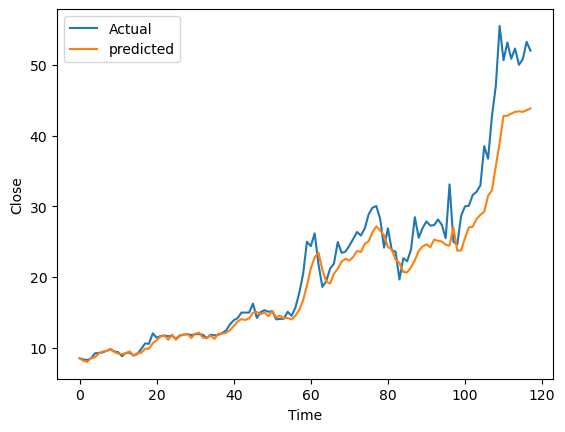

In [ ]:
plt.plot(new_y_test,label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [ ]:
new_df=pd.DataFrame([new_y_test,test_prediction]).T

In [ ]:
new_df=new_df.rename({0:"close",1:"pred_close"},axis=1)

In [ ]:
new_df["returns"]=new_df["close"].pct_change()
new_df["returns_pred"]=new_df["pred_close"].pct_change()

In [ ]:
new_df["direction"]=np.sign(new_df["returns"])
new_df["direction_pred"]=np.sign(new_df["returns_pred"])

In [ ]:
new_df.dropna(inplace=True)

In [ ]:
new_df

,close,pred_close,returns,returns_pred,direction,direction_pred
1,8.350000,8.165770,-0.021102,-0.043703,-1.0,-1.0
2,8.270000,8.007594,-0.009581,-0.019371,-1.0,-1.0
3,8.520000,8.555954,0.030230,0.068480,1.0,1.0
4,9.230000,8.661156,0.083333,0.012296,1.0,1.0
5,9.270000,9.212941,0.004334,0.063708,1.0,1.0
...,...,...,...,...,...,...
113,52.299999,43.347207,0.028515,0.005531,1.0,1.0
114,50.000000,43.425300,-0.043977,0.001802,-1.0,1.0
115,50.799999,43.353747,0.016000,-0.001648,1.0,-1.0
116,53.250000,43.589497,0.048228,0.005438,1.0,1.0


In [ ]:
print("accuracy:", accuracy_score(new_df["direction"], new_df["direction_pred"]))


accuracy: 0.7948717948717948


In [ ]:
from django.http import HttpResponse
from django.shortcuts import render
from django.template import loader
import json


In [ ]:
json.loads(new_df.to_json(orient="records"))

[{'close': 27.1599998474,
  'pred_close': 25.8519878076,
  'returns': 0.0096654362,
  'returns_pred': 0.0329433638,
  'direction': 1.0,
  'direction_pred': 1.0},
 {'close': 26.4400005341,
  'pred_close': 25.5189160978,
  'returns': -0.0265095478,
  'returns_pred': -0.0128837949,
  'direction': -1.0,
  'direction_pred': -1.0},
 {'close': 25.5,
  'pred_close': 25.2412968291,
  'returns': -0.0355522131,
  'returns_pred': -0.0108789601,
  'direction': -1.0,
  'direction_pred': -1.0},
 {'close': 24.5400009155,
  'pred_close': 24.547904519,
  'returns': -0.0376470229,
  'returns_pred': -0.0274705501,
  'direction': -1.0,
  'direction_pred': -1.0},
 {'close': 23.8199996948,
  'pred_close': 24.0717100246,
  'returns': -0.0293399019,
  'returns_pred': -0.0193985802,
  'direction': -1.0,
  'direction_pred': -1.0},
 {'close': 23.8799991608,
  'pred_close': 23.8669347389,
  'returns': 0.0025188693,
  'returns_pred': -0.0085068857,
  'direction': 1.0,
  'direction_pred': -1.0},
 {'close': 24.040000

In [ ]:
a=pd.DataFrame([ ["apple",30],["orange",40],["banana",50],["mango",70],["grape",80]],columns=["labels","y"])
a

,labels,y
0,apple,30
1,orange,40
2,banana,50
3,mango,70
4,grape,80


In [ ]:
json.dumps(json.loads(a.to_json(orient="records")))

'[{"labels": "apple", "y": 30}, {"labels": "orange", "y": 40}, {"labels": "banana", "y": 50}, {"labels": "mango", "y": 70}, {"labels": "grape", "y": 80}]'

In [ ]:
pd.DataFrame([ ["apple",30],["orange",40],["banana",50],["mango",70],["grape",80]],columns=["label","y"]).to_dict(orient="dict")

{'label': {0: 'apple', 1: 'orange', 2: 'banana', 3: 'mango', 4: 'grape'},
 'y': {0: 30, 1: 40, 2: 50, 3: 70, 4: 80}}

In [ ]:
b=dict()
for i in range(len(a)):
    b[a.loc[i,"labels"]]=a.loc[i,"y"]
b

{'apple': 30, 'orange': 40, 'banana': 50, 'mango': 70, 'grape': 80}

In [ ]:
from flask import jsonify
([u.to_json() for u in new_df.to_json()])

AttributeError: 'str' object has no attribute 'to_json'

In [ ]:
a

'"{\\"close\\":{\\"1\\":25.2000007629,\\"2\\":25.3999996185,\\"3\\":25.4400005341,\\"4\\":25.6399993896,\\"5\\":26.8999996185,\\"6\\":27.1599998474,\\"7\\":26.4400005341,\\"8\\":25.5,\\"9\\":24.5400009155,\\"10\\":23.8199996948,\\"11\\":23.8799991608,\\"12\\":24.0400009155,\\"13\\":22.3600006104,\\"14\\":21.8799991608,\\"15\\":23.5799999237,\\"16\\":22.5400009155,\\"17\\":21.0599994659,\\"18\\":19.6700000763,\\"19\\":23.1599998474,\\"20\\":22.9799995422,\\"21\\":22.6800003052,\\"22\\":22.7399997711,\\"23\\":22.6800003052,\\"24\\":22.7800006866,\\"25\\":22.7399997711,\\"26\\":22.2399997711,\\"27\\":23.6000003815,\\"28\\":23.2800006866,\\"29\\":23.5599994659,\\"30\\":23.7399997711,\\"31\\":23.8799991608,\\"32\\":25.7000007629,\\"33\\":25.6599998474,\\"34\\":28.2199993134,\\"35\\":28.0400009155,\\"36\\":28.4599990845,\\"37\\":26.8600006104,\\"38\\":26.3199996948,\\"39\\":26.4400005341,\\"40\\":26.7000007629,\\"41\\":25.5599994659,\\"42\\":25.8999996185,\\"43\\":25.0799999237,\\"44\\":26.1

In [ ]:
def index(request):
    data_points=[new_df.to_json()]
    return render(request, '/home/batuhan-saylam/Desktop/html-css-js/deneme.html', { "data_points" : data_points })                        

In [ ]:
"""from flask import Flask, render_template
import keras_tuner as kt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils import to_categorical
import yfinance as yf
import pandas as pd 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import talib.abstract as ta
import ta as ta2
import tti
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import random
import numpy as np
import pandas_datareader.data as web
import datetime
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
import json
data = yf.download('GARAN.IS',period="7y",interval="1D")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)


data["returns"]=data["close"].pct_change()
from copy import deepcopy as dc
def prepareforlstm(df,lookback):
    df['momentum'] = df['returns'].rolling(5).mean().shift(1)
    df['volatility'] = df['returns'].rolling(20).std().shift(1)
    df['direction'] = np.where(df['returns'] > 0, 1, 0)
    df['distance'] = (df['close'] - df['close'].rolling(50).mean()).shift(1)
    df["mom1"]=ta.MOM(df["close"],1)
    df["mom1"]=df["mom1"].shift(1)
    df["mom2"]=ta.MOM(df["close"],2)
    df["mom2"]=df["mom2"].shift(1)
    df["mom3"]=ta.MOM(df["close"],3)
    df["mom3"]=df["mom3"].shift(1) 
    df["ema_10"]=ta.EMA(df["close"],10)
    df["ema_10"]=df["ema_10"].shift(1)
    df["ema_20"]=ta.EMA(df["close"],20)
    df["ema_20"]=df["ema_20"].shift(1)
    df["ema_50"]=ta.EMA(df["close"],50)
    df["ema_50"]=df["ema_50"].shift(1)
    df["roc5"]=ta.ROC(df["close"],5)
    df["roc5"]=df["roc5"].shift(1)
    df["roc10"]=ta.ROC(df["close"],10)
    df["roc10"]=df["roc10"].shift(1)
    df["roc15"]=ta.ROC(df["close"],15)
    df["roc15"]=df["roc15"].shift(1)
    df["roc20"]=ta.ROC(df["close"],20)
    df["roc20"]=df["roc20"].shift(1)
    df=dc(df)
    for i in range(1,lookback+1):
        df[f'close(t-{i})']=df["close"].shift(i)
    df.dropna(inplace=True)
    df.drop(["low","high","open","adj close","volume","returns"],axis=1,inplace=True)
    
    return df
shifted_df=prepareforlstm(data,7)
shifted_df.info()

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    # gather input and output parts of the pattern
    X, y = sequences.iloc[:, 1:], sequences.iloc[:, 0]
    return np.array(X), np.array(y).reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(shifted_df2, n_steps)
lookback=X.shape[1]
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:].reshape((-1,1,lookback))
x_val=X[split_index:split_index2,:].reshape((-1,1,lookback))
x_test=X[split_index2:,:].reshape((-1,1,lookback))
y_train=Y[:split_index,].reshape((-1,1))
y_val=Y[split_index:split_index2,].reshape((-1,1))
y_test=Y[split_index2:,].reshape((-1,1))
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1.0,0.1,0.01,0.001])
    hp_units=hp.Choice('units', values=[8,16,32,64,128 ])
    with tf.device('/GPU:0'):
        set_seeds()
        model = Sequential()
        model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dense(units=1))
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    return model
tuner=kt.RandomSearch(model_builder,objective="val_loss",overwrite=1,max_trials=5)
tuner.search(x_train,y_train,verbose=1,shuffle=1 ,epochs=100,validation_data=(x_val,y_val),callbacks=[early_stopping])
best_model=tuner.get_best_models()[0]
best_model.evaluate(x_train,y_train)
dummies=np.zeros((x_test.shape[0],shifted_df.shape[1]))
dummies[:,0]=y_test.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
test_prediction=best_model(x_test)
test_prediction.reshape(1,-1)[0]

test_prediction=best_model(x_test)
dummies=np.zeros((x_test.shape[0],shifted_df.shape[1]))
dummies[:,0]=test_prediction.reshape(1,-1)[0]
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction
new_df=pd.DataFrame([new_y_test,test_prediction]).T
new_df=new_df.rename({0:"close",1:"pred_close"},axis=1)
new_df["returns"]=new_df["close"].pct_change()
new_df["returns_pred"]=new_df["pred_close"].pct_change()
new_df["direction"]=np.sign(new_df["returns"])
new_df["direction_pred"]=np.sign(new_df["returns_pred"])
new_df.dropna(inplace=True)
app = Flask(__name__)

@app.route('/')
def hello_world():
    user = json.loads(new_df.to_json())
    return render_template("canvas.html", user=user)

if __name__ == '__main__':
    app.run()"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}')
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                var canvas=document.getElementById('chart');
                var ctx=canvas.getContext('2d');
                var chart= new Chart(ctx,{
                    type: type_chart,
                    data: data_chart,
                    options:chart_options
                  })
                  ;
                
            }
        </script>
        <style type="text/css">
        </style>
    </head>
    <body>
        <div> <canvas id="chart"></canvas></div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ label: i, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ label: i, y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(event)

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                var canvas2=document.getElementById('chart');
                var ctx=canvas2.getContext('2d');
                var chart= new Chart(ctx,{
                    type: type_chart,
                    data: data_chart,
                    options:chart_options
                  })
                  ;
                  var canvas2=document.getElementById('chart2');
                  var ctx=canvas2.getContext('2d');
                  var chart2= new Chart(ctx,config2
                    )
                    ;
                
            }
        </script>
        <style type="text/css">
        </style>
    </head>
    <body>
        <div> <canvas id="chart"></canvas></div>
        <div> <canvas id="chart2"></canvas></div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ label: i, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ label: i, y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                var canvas2=document.getElementById('chart');
                var ctx=canvas2.getContext('2d');
                var chart= new Chart(ctx,{
                    type: type_chart,
                    data: data_chart,
                    options:chart_options
                  })
                  ;
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.label';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].color);
                      vy.push(labels.y);
                      return labels.label;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].backgroundColor=vColor;
                    chart2.config.data.datasets[0].labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler();
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
import yfinance as yf
import pandas as pd 
import talib.abstract as ta
import ta as ta2
import tti
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
import matplotlib.pyplot as plt
import scipy.stats as stats
class strategy:
    def __init__(self,data):
        self.data=data.copy()
        self.data["returns"]=self.data["close"].pct_change()
        self.data["price"]=self.data['close'] /self.data['close'].shift(1)
        self.return_sum=self.data['returns'].sum()*100
        self.data["returns_cumsum"]=self.data['returns'].cumsum()
        self.data["emashort"]=ta.EMA(self.data["close"],10)
        self.data["emalong"]=ta.EMA(self.data["close"],50)
        self.data['positionDMA'] = np.where(self.data['emashort'] > self.data['emalong'],1, -1)
        self.data['strategyDMA'] = self.data['positionDMA'].shift(1) * self.data['returns']
        self.strategyDMA_sum=self.data[ 'strategyDMA'].sum()*100
        self.data[ 'strategyDMA_cumsum']=self.data[ 'strategyDMA'].cumsum()
        self.data["ema"]=ta.EMA(self.data["close"],50)
        self.data['positionMA'] = np.where(self.data['ema'] < self.data['close'],1, -1)
        self.data['strategyMA'] = self.data['positionMA'].shift(1) * self.data['returns']
        self.strategyMA_sum=self.data[ 'strategyMA'].sum()*100
        self.data[ 'strategyMA_cumsum']=self.data[ 'strategyMA'].cumsum()
        self.data["ema_10"]=ta.EMA(self.data["close"],10)
        self.data["ema_25"]=ta.EMA(self.data["close"],25)
        self.data["ema_50"]=ta.EMA(self.data["close"],50)
        self.data['positionTMA'] = np.where((self.data['ema_10'] > self.data['ema_25']) & (self.data['ema_10'] > self.data['ema_50']),1, -1)
        self.data['strategyTMA'] = self.data['positionTMA'].shift(1) * self.data['returns']
        self.strategyTMA_sum=self.data[ 'strategyTMA'].sum()*100
        self.data[ 'strategyTMA_cumsum']=self.data[ 'strategyTMA'].cumsum()
        self.data["ema1"]=ta.EMA(self.data["close"],50)
        self.data["ema2"]=ta.EMA(self.data["close"],50)
        self.data["ema3"]=ta.EMA(self.data["close"],50)
        self.data["tema"]=3*self.data["ema1"]-3*self.data["ema2"]+self.data["ema3"]
        self.data['positionTEMA'] = np.where(self.data['tema'] < self.data['close'],1, -1)
        self.data['strategyTEMA'] = self.data['positionTEMA'].shift(1) * self.data['returns']
        self.strategyTEMA_sum=self.data[ 'strategyTEMA'].sum()*100
        self.data[ 'strategyTMA_cumsum']=self.data[ 'strategyTMA'].cumsum()
        self.data["macdline"]=ta.EMA(self.data["close"],12)-ta.EMA(self.data["close"],26)
        self.data["signalline"]=ta.EMA(pd.DataFrame(self.data["macdline"]).rename({"macdline":"close"},axis=1),9)
        self.data["macdhist"]=self.data["macdline"]-self.data["signalline"]
        self.data['positionMACD'] = np.where(self.data['signalline'] < self.data['macdline'],1, -1)
        self.data['strategyMACD'] = self.data['positionMACD'].shift(1) * self.data['returns']
        self.data["strategyMACD_cumsum"]=self.data[ 'strategyMACD'].cumsum()
        self.strategyMACD_sum=self.data[ 'strategyMACD'].sum()*100
        threshold = 1.5
        self.data['distance'] = stats.zscore(self.data["close"])
        self.data['positionMR'] = np.where(self.data['distance'] > threshold,-1, np.nan)
        self.data['positionMR'] = np.where(self.data['distance'] < -threshold,1, self.data['positionMR'])
        self.data['positionMR'] = np.where(self.data['distance'] *self.data['distance'].shift(1) < 0, 0, self.data['positionMR'])
        self.data['positionMR'] = self.data['positionMR'].ffill().fillna(0)
        self.data['strategyMR'] = self.data['positionMR'].shift(1) * self.data['returns']
        self.strategyMR_sum=self.data[ 'strategyMR'].sum()*100
        self.data[ 'strategyMR_cumsum']=self.data[ 'strategyMR'].dropna().cumsum()

In [ ]:
from flask import *  
import pandas as pd 
import yfinance as yf
data = yf.download('BTC-USD',period="1D",interval="2m")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)
tech=strategy(data)
data2=tech.data.dropna()
data2["time"]=data2.index.astype(str)

data2

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_6455/3724839523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["time"]=data2.index.astype(str)


,open,high,low,close,adj close,volume,returns,price,returns_cumsum,emashort,...,signalline,macdhist,positionMACD,strategyMACD,strategyMACD_cumsum,distance,positionMR,strategyMR,strategyMR_cumsum,time
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-07 01:38:00+00:00,27900.744141,27912.626953,27900.744141,27912.626953,27912.626953,0,0.000507,1.000507,-0.001190,27910.651156,...,-5.658265,-3.665382,-1,-0.000507,-0.001488,-0.670073,0.0,0.000000,0.002254,2023-10-07 01:38:00+00:00
2023-10-07 01:40:00+00:00,27915.501953,27915.501953,27915.183594,27915.183594,27915.183594,0,0.000092,1.000092,-0.001099,27911.475236,...,-6.219053,-2.243153,-1,-0.000092,-0.001580,-0.580503,0.0,0.000000,0.002254,2023-10-07 01:40:00+00:00
2023-10-07 01:42:00+00:00,27908.689453,27908.689453,27903.642578,27903.642578,27903.642578,2072576,-0.000413,0.999587,-0.001512,27910.051116,...,-6.697543,-1.913961,-1,0.000413,-0.001167,-0.984833,0.0,-0.000000,0.002254,2023-10-07 01:42:00+00:00
2023-10-07 01:44:00+00:00,27897.328125,27898.511719,27897.328125,27898.511719,27898.511719,461824,-0.000184,0.999816,-0.001696,27907.953044,...,-7.165962,-1.873676,-1,0.000184,-0.000983,-1.164588,0.0,-0.000000,0.002254,2023-10-07 01:44:00+00:00
2023-10-07 01:46:00+00:00,27900.373047,27901.613281,27900.373047,27901.613281,27901.613281,1000448,0.000111,1.000111,-0.001585,27906.800360,...,-7.537697,-1.486939,-1,-0.000111,-0.001094,-1.055928,0.0,0.000000,0.002254,2023-10-07 01:46:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-07 10:04:00+00:00,27966.810547,27966.810547,27965.960938,27965.960938,27965.960938,0,-0.000030,0.999970,0.000725,27968.996754,...,-3.652274,-0.899700,-1,0.000030,-0.002010,1.198440,-1.0,0.000030,0.003987,2023-10-07 10:04:00+00:00
2023-10-07 10:06:00+00:00,27965.960938,27965.960938,27964.351562,27964.351562,27964.351562,7259136,-0.000058,0.999942,0.000668,27968.152174,...,-3.853910,-0.806546,-1,0.000058,-0.001952,1.142057,-1.0,0.000058,0.004045,2023-10-07 10:06:00+00:00
2023-10-07 10:08:00+00:00,27964.351562,27969.828125,27964.351562,27969.828125,27969.828125,0,0.000196,1.000196,0.000864,27968.456892,...,-3.934221,-0.321242,-1,-0.000196,-0.002148,1.333924,-1.0,-0.000196,0.003849,2023-10-07 10:08:00+00:00


In [ ]:
a=pd.DataFrame([ ["return",tech.return_sum],["MA",tech.strategyMA_sum],["DMA",tech.strategyDMA_sum],["TMA",tech.strategyTMA_sum],["TEMA",tech.strategyTEMA_sum],["MACD",tech.strategyMACD_sum],["MR",tech.strategyMR_sum]],columns=["label","y"])
data2=json.dumps(json.loads(data2.to_json(orient="records")))

In [ ]:
data2

'[{"open": 27900.744140625, "high": 27912.626953125, "low": 27900.744140625, "close": 27912.626953125, "adj close": 27912.626953125, "volume": 0, "returns": 0.0005067899, "price": 1.0005067899, "returns_cumsum": -0.0011904467, "emashort": 27910.6511559338, "emalong": 27928.488046875, "positionDMA": -1, "strategyDMA": -0.0005067899, "strategyDMA_cumsum": 0.0011904467, "ema": 27928.488046875, "positionMA": -1, "strategyMA": -0.0005067899, "strategyMA_cumsum": 0.0011904467, "ema_10": 27910.6511559338, "ema_25": 27921.9631288063, "ema_50": 27928.488046875, "positionTMA": -1, "strategyTMA": -0.0005067899, "strategyTMA_cumsum": 0.0011904467, "ema1": 27928.488046875, "ema2": 27928.488046875, "ema3": 27928.488046875, "tema": 27928.488046875, "positionTEMA": -1, "strategyTEMA": -0.0005067899, "macdline": -9.3236471432, "signalline": -5.6582648811, "macdhist": -3.665382262, "positionMACD": -1, "strategyMACD": -0.0005067899, "strategyMACD_cumsum": -0.001488394, "distance": -0.6700726088, "positio

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ label: i, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ label: i, y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                var canvas2=document.getElementById('chart');
                var ctx=canvas2.getContext('2d');
                var chart= new Chart(ctx,{
                    type: type_chart,
                    data: data_chart,
                    options:chart_options
                  })
                  ;
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.label';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].color);
                      vy.push(labels.y);
                      return labels.label;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].backgroundColor=vColor;
                    chart2.config.data.datasets[0].labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart"></canvas></div>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ label: i.toString(), y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ label: i.toString(), y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.label';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].borderColor);
                      vy.push(labels.y);
                      return labels.label;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].borderColor=vColor;
                    chart2.config.data.datasets[0].labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
            const config3={
              type: 'line',
              data: data_chart2,
              options: {
                onhover:(event,chartElement)=>{
                  console.log(chartElement[0])
                  event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                },
                parsing:{
                  xAxisKey: 'label',
                  yAxisKey: 'data'
                },
                scales: {
                  y: {
                      beginAtZero:true
                  }
                }

            }
          };
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].borderColor);
                      vy.push(labels.y);
                      return labels.time;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].borderColor=vColor;
                    chart2.config.data.datasets[0].labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var labels = data3.map(function(e) {
                    return e.label;});
                var data4=data3.map(function(e) {
                    return e.y;});
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
            };
            var data_return_cumsum2=data3_tech.map(function(e) {
              return e.returns_cumsum;;
            });
          var data_MA_cumsum2=data3_tech.map(function(e) {
            return e.strategyMA_cumsum;;
          });
          var time=data3_tech.map(function(e) {
            return e.time});
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(75, 192, 192)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
            const config3={
              type: 'line',
              data: {
                labels: time,
                datasets:[{
                data:data_return_cumsum2}]
              },
              options: {
                scales: {
                  y: {
                      beginAtZero:true
                  }
                }

            }
          };
          var ctx2=document.getElementById('chart3');
          const chart3= new Chart(ctx2,config3
            );
                var data_chart={
                    labels: labels,
                    datasets: [{
                      label: '# of Votes',
                      data: data4,
                      backgroundColor: [
                      'rgba(255, 99, 132, 0.2)',
                      'rgba(255, 159, 64, 0.2)',
                      'rgba(255, 205, 86, 0.2)',
                      'rgba(75, 192, 192, 0.2)',
                      'rgba(54, 162, 235, 0.2)',
                      'rgba(153, 102, 255, 0.2)',
                      'rgba(201, 203, 207, 0.2)'
                    ],
                    borderColor: [
                      'rgb(255, 99, 132)',
                      'rgb(255, 159, 64)',
                      'rgb(255, 205, 86)',
                      'rgb(75, 192, 192)',
                      'rgb(54, 162, 235)',
                      'rgb(153, 102, 255)',
                      'rgb(201, 203, 207)'
                    ],
                    borderWidth: 1
                    }]
                  };
                var type_chart='bar';
                var chart_options={
                    responsive: true,
                    scales: {
                      y: {
                        beginAtZero: true
                      }
                    }
                  };
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].borderColor);
                      vy.push(labels.y);
                      return labels.time;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].borderColor=vColor;
                    chart2.config.data.labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
      <div> <canvas id="chart3"></canvas></div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var data_return_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
              };
              var data_MA_cumsum=[];
              for(var i=0; i<data3_tech.length; i++) {
                data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
            };
              const return_data=[
              {
                label:'return',
                color:'rgba(255, 99, 132, 0.2)',
                borderColor:'rgb(255, 99, 132)',
                data:data3[0].y,
                strategy_data:data_return_cumsum
              },
              {
                label:'MA',
                color:'rgba(255, 159, 64, 0.2)',
                borderColor:'rgb(255, 159, 64)',
                data:data3[1].y,
                strategy_data:data_MA_cumsum
              }
              ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].borderColor);
                      vy.push(labels.y);
                      return labels.time;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].borderColor=vColor;
                    chart2.config.data.labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
"""<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
              var data_chart2={
                datasets: [{
                  label: '# of Votes',
                  data: return_data,
                  backgroundColor: [
                  return_data[0].color,
                  return_data[1].color,
                  return_data[2].color,
                  return_data[3].color,
                  return_data[4].color,
                  return_data[5].color,
                  return_data[6].color
                ],
                borderColor: [
                return_data[0].borderColor,
                return_data[1].borderColor,
                return_data[2].borderColor,
                return_data[3].borderColor,
                return_data[4].borderColor,
                return_data[5].borderColor,
                return_data[6].borderColor
                ],
                borderWidth: 1
                }]
              };
              const config2={
                type: 'bar',
                data: data_chart2,
                options: {
                  onhover:(event,chartElement)=>{
                    console.log(chartElement[0])
                    event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                  },
                  parsing:{
                    xAxisKey: 'label',
                    yAxisKey: 'data'
                  },
                  scales: {
                    y: {
                        beginAtZero:true
                    }
                  }

              }
            };
                  var ctx=document.getElementById('chart2');
                  const chart2= new Chart(ctx,config2
                    );
                  function changeChart(label){
                    chart2.config.type="line";
                    chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                    chart2.config.options.parsing.yAxisKey='strategy_data.y';
                    const vColor=[];
                    const vy=[];
                    const vLabels=return_data[label].strategy_data.map(labels=>{
                      vColor.push(return_data[label].borderColor);
                      vy.push(labels.y);
                      return labels.time;
                    })
                    console.log(vLabels)
                    chart2.config.data.datasets[0].data=vy;
                    chart2.config.data.datasets[0].borderColor=vColor;
                    chart2.config.data.labels=vLabels;
                    chart2.config.data.datasets[0].label=return_data[label].label;
                    chart2.update();
                  };
                  function clickhandler(click){
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  };
                  ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: '# of Votes',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  }]
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    onhover:(event,chartElement)=>{
                      console.log(chartElement[0])
                      event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  }
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.update();
                };
                function clickhandler(click){
                  const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                  console.log(bar);
                  if(bar.length){
                    console.log(bar[0].index);
                    changeChart(bar[0].index);
                  }
                };
                ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: '# of Votes',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  }]
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    onhover:(event,chartElement)=>{
                      console.log(chartElement[0])
                      event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  }
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vBackColor=[];
                  const vBColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vBackColor.push(return_data[label].color);
                    vBColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vBColor;
                  chart2.config.data.datasets[0].backgroundColor=vBackColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.update();
                };
                function clickhandler(click){
                  const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                  console.log(bar);
                  if(bar.length){
                    console.log(bar[0].index);
                    changeChart(bar[0].index);
                  }
                };
                ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                const returns=data3_tech.map(function(e) {
                  return e.returns_cumsum;});
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: '# of Votes',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  },
                  {}]
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    onhover:(event,chartElement)=>{
                      console.log(chartElement[0])
                      event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  }
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vBackColor=[];
                  const vBColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vBackColor.push(return_data[label].color);
                    vBColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vBColor;
                  chart2.config.data.datasets[0].backgroundColor=vBackColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.config.data.datasets[1].data=returns;
                  chart2.config.data.datasets[1].borderColor='rgb(255, 99, 132)';
                  chart2.config.data.datasets[1].backgroundColor='rgba(255, 99, 132, 0.2)';
                  chart2.config.data.datasets[1].label="Returns";
                  chart2.update();
                };
                function clickhandler(click){
                  const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                  console.log(bar);
                  if(bar.length){
                    console.log(bar[0].index);
                    changeChart(bar[0].index);
                  }
                };
                ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                const returns=data3_tech.map(function(e) {
                  return e.returns_cumsum;});
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: '# of Votes',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  },
                  {}]
                };
                const resetButton={
                  id:"resetButton",
                  beforeDraw(chart,args,options){

                    
                    const {ctx,chartArea:{ top , bottom, left, right, width, height }}= chart;
                    ctx.save();
                    const text="Back";
                    const thickBorder=3;
                    const textWidth=ctx.measureText(text).width;
                    //background
                    ctx.fillStyle='rgba(255,26,104,0.2)';
                    ctx.fillRect(right-(textWidth+11),5,textWidth+10,20);

                    //text
                    ctx.fillStyle='#666';
                    ctx.font='12px Arial';
                    ctx.fillText(text,right-(textWidth+6),15);

                    //border
                    ctx.lineWidth = thickBorder+'px';
                    ctx.strokeStyle = 'rgba(255,26,104,1)';
                    ctx.strokeRect(right-(textWidth+11),5,textWidth+10,20);
                    ctx.restore();
                  }
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    plugins:{
                      tooltip: {
                        yAlign:'bottom',
                      }
                    },
                    onhover:(event,chartElement)=>{
                      console.log(chartElement[0])
                      event.native.target.style.cursor=chartElement[0] ? 'pointer' : 'default';

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  },
                  plugins: [resetButton]
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vBackColor=[];
                  const vBColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vBackColor.push(return_data[label].color);
                    vBColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vBColor;
                  chart2.config.data.datasets[0].backgroundColor=vBackColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.config.data.datasets[1].data=returns;
                  chart2.config.data.datasets[1].borderColor='rgb(255, 99, 132)';
                  chart2.config.data.datasets[1].backgroundColor='rgba(255, 99, 132, 0.2)';
                  chart2.config.data.datasets[1].label="Returns";
                  chart2.update();
                };
                function clickhandler(click){
                  const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                  console.log(bar);
                  if(bar.length){
                    console.log(bar[0].index);
                    changeChart(bar[0].index);
                  }
                };
                ctx.onclick = clickhandler;
                
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                const coordinates={
                  top:0,
                  bottom:0,
                  left:0,
                  right:0
                };
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                const returns=data3_tech.map(function(e) {
                  return e.returns_cumsum;});
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: 'All Returns',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  },
                  {}]
                };
                const resetButton={
                  id:"resetButton",
                  beforeDraw(chart,args,options){
                    if(chart2.config.data.datasets[0].label !== "All Returns"){
                    
                      const {ctx,chartArea:{ top , bottom, left, right, width, height }}= chart;
                      ctx.save();
                      const text="Back";
                      const thickBorder=3;
                      const textWidth=ctx.measureText(text).width;
                      //background
                      ctx.fillStyle='rgba(255,26,104,0.2)';
                      ctx.fillRect(right-(textWidth+11),5,textWidth+10,20);

                      //text
                      ctx.fillStyle='#666';
                      ctx.font='12px Arial';
                      ctx.fillText(text,right-(textWidth+6),15);

                      //border
                      ctx.lineWidth = thickBorder+'px';
                      ctx.strokeStyle = 'rgba(255,26,104,1)';
                      ctx.strokeRect(right-(textWidth+11),5,textWidth+10,20);

                      coordinates.top=5;
                      coordinates.bottom=25;
                      coordinates.left=right-(textWidth+11);
                      coordinates.right=right;
                      ctx.restore();
                    };
                  }
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    plugins:{
                      tooltip: {
                        yAlign:'bottom',
                      }
                    },
                    onhover:(event,chartElement)=>{
                      if(chart2.config.data.datasets[0].label==='All Returns')
                      {
                        event.native.target.style.cursor=chartElement[0] ? 'pointer' :'default';

                      } else {
                        event.native.target.style.cursor='default';
                      };

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  },
                  plugins: [resetButton]
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vBackColor=[];
                  const vBColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vBackColor.push(return_data[label].color);
                    vBColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vBColor;
                  chart2.config.data.datasets[0].backgroundColor=vBackColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.config.data.datasets[1].data=returns;
                  chart2.config.data.datasets[1].borderColor='rgb(255, 99, 132)';
                  chart2.config.data.datasets[1].backgroundColor='rgba(255, 99, 132, 0.2)';
                  chart2.config.data.datasets[1].label="Returns";
                  chart2.update();
                };
                function clickhandler(click){
                  if(chart2.config.data.datasets[0].label==="All Returns"){

                
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  }
                };
                function resetChart(){
                  chart2.config.options.parsing.xAxisKey='label';
                  chart2.config.options.parsing.yAxisKey='data';
                  const bColor=[];
                  const bData=[];
                  const bBColor=[]; 
                  const bLabels=return_data.map(label=>{
                    bColor.push(label.color);
                    bData.push(label.data);
                    bBColor.push(label.borderColor);
                    return label.label;
                  });
                  chart2.config.type='bar';
                  chart2.config.data.datasets[0].backgroundColor=bColor;
                  chart2.config.data.datasets[0].borderColor=bBColor;
                  chart2.config.data.datasets[0].label="All Returns";
                  chart2.config.data.labels=bLabels;
                  chart2.config.data.datasets[0].data=bData;
                  chart2.config.data.datasets[1]={};
                  chart2.update();
                };
                function mousemoveHandler(ctx,mousemove){
                  const x=mousemove.offsetX;
                  const y=mousemove.offsetY;
                  if(chart2.config.data.datasets[0].label !== "All Returns"){

                    if(x>coordinates.left && x<coordinates.right && y>coordinates.top && y<coordinates.bottom){
                      canvas.style.cursor='pointer';
                    }else {
                      canvas.style.cursor='default';
                    };
                };

                };
                function clickButtonHandler(canvas,click){
                  const x=click.offsetX;
                  const y=click.offsetY;
                  if(x>coordinates.left && x<coordinates.right && y>coordinates.top && y<coordinates.bottom){
                    resetChart();
                  }
                };
                ctx.onclick = clickhandler;
                ctx.addEventListener('mousemove',(e)=>{
                  chart2.resize();
                  mousemoveHandler(ctx,e);
                });
                ctx.addEventListener('click',(e)=>{
                  chart2.resize();
                  clickButtonHandler(ctx.e)
                })
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""

In [ ]:
"""
<html>
    <head>
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>CanvasJS Chart Python Flask Sample</title>
        <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <script type="text/javascript">
            window.onload = function() {
                const coordinates={
                  top:0,
                  bottom:0,
                  left:0,
                  right:0
                };
                data3=JSON.parse('{{ data|safe }}');
                data3_tech=JSON.parse('{{ data2|safe }}');
                const returns=data3_tech.map(function(e) {
                  return e.returns_cumsum;});
                var data_return_cumsum=[];
                var data_MA_cumsum=[];
                var data_DMA_cumsum=[];
                var data_TMA_cumsum=[];
                var data_TEMA_cumsum=[];
                var data_MACD_cumsum=[];
                var data_MR_cumsum=[];
                for(var i=0; i<data3_tech.length; i++) {
                  data_return_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].returns_cumsum });
                  data_MA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMA_cumsum });
                  data_DMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyDMA_cumsum });
                  data_TMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTMA_cumsum });
                  data_TEMA_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyTEMA_cumsum });
                  data_MACD_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMACD_cumsum });
                  data_MR_cumsum.push({ time: data3_tech[i].time, y: data3_tech[i].strategyMR_cumsum });

                };
                const return_data=[
                {
                  label:'return',
                  color:'rgba(255, 99, 132, 0.2)',
                  borderColor:'rgb(255, 99, 132)',
                  data:data3[0].y,
                  strategy_data:data_return_cumsum
                },
                {
                  label:'MA',
                  color:'rgba(255, 159, 64, 0.2)',
                  borderColor:'rgb(255, 159, 64)',
                  data:data3[1].y,
                  strategy_data:data_MA_cumsum
                },
                {
                  label:'DMA',
                  color:'rgba(255, 205, 86, 0.2)',
                  borderColor:'rgb(255, 205, 86)',
                  data:data3[2].y,
                  strategy_data:data_DMA_cumsum
                },
                {
                  label:'TMA',
                  color:'rgba(75, 192, 192, 0.2)',
                  borderColor:'rgb(75, 192, 192)',
                  data:data3[3].y,
                  strategy_data:data_TMA_cumsum
                },
                {
                  label:'TEMA',
                  color:'rgba(54, 162, 235, 0.2)',
                  borderColor:'rgb(54, 162, 235)',
                  data:data3[4].y,
                  strategy_data:data_TEMA_cumsum
                },
                {
                  label:'MACD',
                  color:'rgba(153, 102, 255, 0.2)',
                  borderColor:'rgb(153, 102, 255)',
                  data:data3[5].y,
                  strategy_data:data_MACD_cumsum
                },
                {
                  label:'MR',
                  color:'rgba(201, 203, 207, 0.2)',
                  borderColor:'rgb(201, 203, 207)',
                  data:data3[6].y,
                  strategy_data:data_MR_cumsum
                }
                ];
                var data_chart2={
                  datasets: [{
                    label: 'All Returns',
                    data: return_data,
                    backgroundColor: [
                    return_data[0].color,
                    return_data[1].color,
                    return_data[2].color,
                    return_data[3].color,
                    return_data[4].color,
                    return_data[5].color,
                    return_data[6].color
                  ],
                  borderColor: [
                    return_data[0].borderColor,
                    return_data[1].borderColor,
                    return_data[2].borderColor,
                    return_data[3].borderColor,
                    return_data[4].borderColor,
                    return_data[5].borderColor,
                    return_data[6].borderColor
                  ],
                  borderWidth: 1
                  },
                  {}]
                };
                const resetButton={
                  id:"resetButton",
                  beforeDraw(chart,args,options){
                    if(chart2.config.data.datasets[0].label !== "All Returns"){
                    
                      const {ctx,chartArea:{ top , bottom, left, right, width, height }}= chart;
                      ctx.save();
                      const text="Back";
                      const thickBorder=3;
                      const textWidth=ctx.measureText(text).width;
                      //background
                      ctx.fillStyle='rgba(255,26,104,0.2)';
                      ctx.fillRect(right-(textWidth+11),5,textWidth+10,20);

                      //text
                      ctx.fillStyle='#666';
                      ctx.font='12px Arial';
                      ctx.fillText(text,right-(textWidth+6),15);

                      //border
                      ctx.lineWidth = thickBorder+'px';
                      ctx.strokeStyle = 'rgba(255,26,104,1)';
                      ctx.strokeRect(right-(textWidth+11),5,textWidth+10,20);

                      coordinates.top=5;
                      coordinates.bottom=25;
                      coordinates.left=right-(textWidth+11);
                      coordinates.right=right;
                      ctx.restore();
                    };
                  }
                };
                const config2={
                  type: 'bar',
                  data: data_chart2,
                  options: {
                    plugins:{
                      tooltip: {
                        yAlign:'bottom',
                      }
                    },
                    onhover:(event,chartElement)=>{
                      if(chart2.config.data.datasets[0].label==='All Returns')
                      {
                        event.native.target.style.cursor=chartElement[0] ? 'pointer' :'default';

                      } else {
                        event.native.target.style.cursor='default';
                      };

                    },
                    parsing:{
                      xAxisKey: 'label',
                      yAxisKey: 'data'
                    },
                    scales: {
                      y: {
                          beginAtZero:true
                      }
                    }

                  },
                  plugins: [resetButton]
                };
                var ctx=document.getElementById('chart2');
                const chart2= new Chart(ctx,config2);
                function changeChart(label){
                  chart2.config.type="line";
                  chart2.config.options.parsing.xAxisKey = 'strategy_data.time';
                  chart2.config.options.parsing.yAxisKey='strategy_data.y';
                  const vBackColor=[];
                  const vBColor=[];
                  const vy=[];
                  const vLabels=return_data[label].strategy_data.map(labels=>{
                    vBackColor.push(return_data[label].color);
                    vBColor.push(return_data[label].borderColor);
                    vy.push(labels.y);
                    return labels.time;
                  })
                  console.log(vLabels)
                  chart2.config.data.datasets[0].data=vy;
                  chart2.config.data.datasets[0].borderColor=vBColor;
                  chart2.config.data.datasets[0].backgroundColor=vBackColor;
                  chart2.config.data.labels=vLabels;
                  chart2.config.data.datasets[0].label=return_data[label].label;
                  chart2.config.data.datasets[1].data=returns;
                  chart2.config.data.datasets[1].borderColor='rgb(255, 99, 132)';
                  chart2.config.data.datasets[1].backgroundColor='rgba(255, 99, 132, 0.2)';
                  chart2.config.data.datasets[1].label="Returns";
                  chart2.update();
                };
                function clickhandler(click){
                  if(chart2.config.data.datasets[0].label==="All Returns"){

                
                    const bar=chart2.getElementsAtEventForMode(click,'nearest',{intersect:true},true);
                    console.log(bar);
                    if(bar.length){
                      console.log(bar[0].index);
                      changeChart(bar[0].index);
                    }
                  }
                };
                function resetChart(){
                  chart2.config.options.parsing.xAxisKey='label';
                  chart2.config.options.parsing.yAxisKey='data';
                  const bColor=[];
                  const bData=[];
                  const bBColor=[]; 
                  const bLabels=return_data.map(label=>{
                    bColor.push(label.color);
                    bData.push(label.data);
                    bBColor.push(label.borderColor);
                    return label.label;
                  });
                  chart2.config.type='bar';
                  chart2.config.data.datasets[0].backgroundColor=bColor;
                  chart2.config.data.datasets[0].borderColor=bBColor;
                  chart2.config.data.datasets[0].label="All Returns";
                  chart2.config.data.labels=bLabels;
                  chart2.config.data.datasets[0].data=bData;
                  chart2.config.data.datasets[1]={};
                  chart2.update();
                };
                function mousemoveHandler(ctx,mousemove){
                  const x=mousemove.offsetX;
                  const y=mousemove.offsetY;
                  if(chart2.config.data.datasets[0].label !== "All Returns"){

                    if(x>coordinates.left && x<coordinates.right && y>coordinates.top && y<coordinates.bottom){
                      canvas.style.cursor='pointer';
                    }else {
                      canvas.style.cursor='default';
                    };
                };

                };
                function clickButtonHandler(canvas,click){
                  const x=click.offsetX;
                  const y=click.offsetY;
                  if(x>coordinates.left && x<coordinates.right && y>coordinates.top && y<coordinates.bottom){
                    resetChart();
                  }
                };
                ctx.onclick = clickhandler;
                ctx.addEventListener('mousemove',(e)=>{
                  chart2.resize();
                  mousemoveHandler(ctx,e);
                });
                ctx.addEventListener('click',(e)=>{
                  chart2.resize();
                  clickButtonHandler(ctx,e)
                });
            }
        </script>
        <style>
        * {
          margin: 0;
          padding:0;
          font-family:sams=serif;
        }
        .chartMenu {
          width:100vw;
          height:100px;
          backgroundColor:#1A1A1A;
          color:rgba(255,26,184,1);
        }
        .chartMenu p {
          padding:10px;
          font-size:20px;
        }
        .chartCard {
          width:100vw;
          height:calc(100vh-40px);
          background-color:rgba(255,26,184,0.2);
          display:flex;
          align-items:center;
          justify-content:center;
        }
        .chartBox {
          width:700px;
          padding:20px;
          border-radius:20px;
          border:solid 3px rgba(255,26,184,1);
          background:white;
        }
        </style>
    </head>
    <body>
      <div class="chartMenu">
        <p>Python Flask Chart</p>
      </div>
      <div class="chartCard">
        <div class="chartBox"> <canvas id="chart2"></canvas></div>
      </div>
    </body>
</html>
"""